In [1]:
import recordlinkage as rl
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
import matplotlib.pyplot as plt

In [2]:
PATH_DATA = "../data/"
PATH_OUTPUT_CSV = "../output/febrl_csv/"
PATH_OUTPUT_IMG = "../output/febrl_img/"
FILE_NAME_FEBRL3 = PATH_DATA + "febrl3_reproduced.csv"
FILE_NAME_FEBRL4 = PATH_DATA + "febrl4_reproduced.csv"

Data loading

In [3]:
df_febrl3 = pd.read_csv(FILE_NAME_FEBRL3, index_col="rec_id")
df_febrl4 = pd.read_csv(FILE_NAME_FEBRL4, index_col="rec_id")

Helper functions

In [4]:
def links_generation(df_febrl):
    ind_first = []
    ind_second = []
    df_febrl["rec_id"] = df_febrl.index.values.tolist()
    cur = 0
    df_febrl_u = df_febrl["match_id"].unique()
    for match_id in df_febrl_u:
        if match_id != -1:
            cur += 1
            matches = df_febrl.loc[df_febrl["match_id"] == match_id]
            for m in range(len(matches) - 1):
                matches_len = len(matches)
                start = m + 1
                for k in range(start, matches_len):
                    ind_first += [matches.iloc[m]["rec_id"]]
                    ind_second += [matches.iloc[k]["rec_id"]]
    links = pd.MultiIndex.from_arrays([ind_first, ind_second])
    return links

def false_links_generation(df, size):
    ind_first = []
    ind_second = []
    df["rec_id"] = df.index.values.tolist()
    unique_match_id = df["match_id"].unique()
    for s in range(size):
        false_pair_ids = np.random.choice(unique_match_id, 2)
        candidate_1_cluster = df.loc[df["match_id"] == false_pair_ids[0]]
        candidate_1 = candidate_1_cluster.iloc[np.random.choice(range(len(candidate_1_cluster)))]
        candidate_2_cluster = df.loc[df["match_id"] == false_pair_ids[1]]
        candidate_2 = candidate_2_cluster.iloc[np.random.choice(range(len(candidate_2_cluster)))]
        ind_first += [candidate_1["rec_id"]]
        ind_second += [candidate_2["rec_id"]]
    links = pd.MultiIndex.from_arrays([ind_first, ind_second])
    return links

def feature_extraction(df, links):
    c = rl.Compare()
    c.string("given_name", "given_name", method="jarowinkler", label="y_name")
    c.string("given_name_soundex", "given_name_soundex", method="jarowinkler", label="y_name_soundex")
    c.string("given_name_nysiis", "given_name_nysiis", method="jarowinkler", label="y_name_nysiis")
    c.string("surname", "surname", method="jarowinkler", label="y_surname")
    c.string("surname_soundex", "surname_soundex", method="jarowinkler", label="y_surname_soundex")
    c.string("surname_nysiis", "surname_nysiis", method="jarowinkler", label="y_surname_nysiis")
    c.exact("street_number", "street_number", label="y_street_number")
    c.string("address_1", "address_1", method="levenshtein", threshold=0.7, label="y_address1")
    c.string("address_2", "address_2", method="levenshtein", threshold=0.7, label="y_address2")
    c.exact("postcode", "postcode", label="y_postcode")
    c.exact("day", "day", label="y_day")
    c.exact("month", "month", label="y_month")
    c.exact("year", "year", label="y_year")

    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def model_training(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == "svm":
        model = svm.SVC(C=modelparam, kernel=modeltype_2)
        model.fit(train_vectors, train_labels)
    elif modeltype == "lg":
        if modeltype_2 == "l1":
            model = LogisticRegression(C=modelparam, penalty=modeltype_2, class_weight=None, dual=False, fit_intercept=True,
                intercept_scaling=1, max_iter=500, multi_class="ovr", n_jobs=1, random_state=None, solver="liblinear")
        if modeltype_2 == "l2":
            model = LogisticRegression(C=modelparam, penalty=modeltype_2, class_weight=None, dual=False, fit_intercept=True,
                intercept_scaling=1, max_iter=500, multi_class="ovr", n_jobs=1, random_state=None)
        model.fit(train_vectors, train_labels)
    elif modeltype == "nn":  
        model = MLPClassifier(solver="lbfgs", alpha=modelparam, hidden_layer_sizes=(256,), activation=modeltype_2, random_state=None,
            batch_size="auto", learning_rate="constant", learning_rate_init=0.001, power_t=0.5, max_iter=1000, shuffle=True,
            tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
            validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    elif modeltype == "rf":
        model = RandomForestClassifier(n_estimators=100, criterion=modeltype_2, max_depth=7, min_samples_leaf=1,
            min_weight_fraction_leaf=0.0, max_features="sqrt", max_leaf_nodes=None, min_impurity_decrease=modelparam,
            bootstrap=True, oob_score=False, random_state=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
        model.fit(train_vectors, train_labels)

    return model

def performance_evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)

    true_neg = np.logical_and(np.logical_not(test_labels), np.logical_not(result))
    count_true_neg = np.sum(true_neg)

    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)

    false_neg = np.logical_and(test_labels, np.logical_not(result))
    count_false_neg = np.sum(false_neg)

    if count_true_pos == 0 and count_false_pos == 0:
        precision = 0
    else:
        precision = count_true_pos / (count_true_pos + count_false_pos)

    if count_true_pos == 0 and count_false_neg == 0:
        sensitivity = 0
    else:
        sensitivity = count_true_pos / (count_true_pos + count_false_neg)
        
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    
    if precision == 0 and sensitivity == 0:
        Fscore = 0
    else:    
        Fscore = 2 * precision * sensitivity / (precision + sensitivity)

    metrics_result = {"no_false": no_false, "confusion_matrix": confusion_matrix, "precision": precision,"sensitivity": sensitivity,
        "no_links": no_links_found, "F-score": Fscore, "true_pos": count_true_pos, "true_neg": count_true_neg,
        "false_pos": count_false_pos, "false_neg": count_false_neg}

    return metrics_result

Training data preparation

In [5]:
febrl3_links = links_generation(df_febrl3)

df_febrl3["postcode"] = df_febrl3["postcode"].astype(str)
df_febrl3["given_name_soundex"] = phonetic(df_febrl3["given_name"], method="soundex")
df_febrl3["given_name_nysiis"] = phonetic(df_febrl3["given_name"], method="nysiis")
df_febrl3["surname_soundex"] = phonetic(df_febrl3["surname"], method="soundex")
df_febrl3["surname_nysiis"] = phonetic(df_febrl3["surname"], method="nysiis")

pos = feature_extraction(df_febrl3, febrl3_links)
train_false_links = false_links_generation(df_febrl3, len(febrl3_links))
neg = feature_extraction(df_febrl3, train_false_links)
X_febrl3_train = pos.values.tolist() + neg.values.tolist()
y_febrl3_train = [1] * len(pos) + [0] * len(neg)
X_febrl3_train, y_febrl3_train = shuffle(X_febrl3_train, y_febrl3_train, random_state=0)
X_febrl3_train = np.array(X_febrl3_train)
y_febrl3_train = np.array(y_febrl3_train)

Testing data preparation

In [6]:
test_true_links = links_generation(df_febrl4)
leng_test_true_links = len(test_true_links)

blocking_fields = ["given_name", "surname", "postcode"]
cand_pairs = []
for field in blocking_fields:
    block = rl.Index()
    block.block(on=field)
    candidates = block.index(df_febrl4)
    cand_pairs = candidates.union(cand_pairs)

df_febrl4["postcode"] = df_febrl4["postcode"].astype(str)
df_febrl4["given_name_soundex"] = phonetic(df_febrl4["given_name"], method="soundex")
df_febrl4["given_name_nysiis"] = phonetic(df_febrl4["given_name"], method="nysiis")
df_febrl4["surname_soundex"] = phonetic(df_febrl4["surname"], method="soundex")
df_febrl4["surname_nysiis"] = phonetic(df_febrl4["surname"], method="nysiis")

df_X_test = feature_extraction(df_febrl4, cand_pairs)
vectors = df_X_test.values.tolist()
labels = [0] * len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if (df_febrl4.loc[feature_index[i][0]]["match_id"] == df_febrl4.loc[feature_index[i][1]]["match_id"]):
        labels[i] = 1
X_febrl4_test, y_febrl4_test = shuffle(vectors, labels, random_state=0)
X_febrl4_test = np.array(X_febrl4_test)
y_febrl4_test = np.array(y_febrl4_test)


Training and testing base learners

In [7]:
print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")
models = {"svm": ["linear", "rbf"], "lg": ["l1", "l2"], "nn": ["relu", "logistic"], "rf": ["gini", "entropy"]}

modelparam_range = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

df_precision = pd.DataFrame()
df_precision["param"] = modelparam_range

df_sensitivity = pd.DataFrame()
df_sensitivity["param"] = modelparam_range

df_fscore = pd.DataFrame()
df_fscore["param"] = modelparam_range

df_nb_false = pd.DataFrame()
df_nb_false["param"] = modelparam_range

for i in models:
    for j in models[i]:
        print("Model:", i, ", Param_1:", j, ", tuning range:", modelparam_range)
        precision = []
        sensitivity = []
        Fscore = []
        nb_false = []

        for modelparam in modelparam_range:
            md = model_training(i, modelparam, X_febrl3_train, y_febrl3_train, j)
            final_result = md.predict(X_febrl4_test)
            final_eval = performance_evaluation(y_febrl4_test, final_result)
            precision += [final_eval["precision"]]
            sensitivity += [final_eval["sensitivity"]]
            Fscore += [final_eval["F-score"]]
            nb_false += [final_eval["no_false"]]

        df_precision[i + "-" + j] = precision
        df_sensitivity[i + "-" + j] = sensitivity
        df_fscore[i + "-" + j] = Fscore
        df_nb_false[i + "-" + j] = nb_false

        print("No_false:", nb_false, "\n")
        print("Precision:", precision, "\n")
        print("Sensitivity:", sensitivity, "\n")
        print("F-score:", Fscore, "\n")
        print("")
        

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: linear , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [112, 99, 297, 569, 839, 1789, 2521, 2690, 5995, 6646, 6837, 6849, 6765, 6725, 6713, 6714, 6713, 6713, 6709, 6683] 

Precision: [0.9929896907216494, 0.9836594714545088, 0.9453594264677389, 0.8974453225510016, 0.8550166345648748, 0.7327237295757757, 0.6602728623531001, 0.6455361859482304, 0.44938861818516135, 0.42401110340041637, 0.41710043519071593, 0.41667377035205866, 0.4196788872671074, 0.42112518307917635, 0.4215610176800345, 0.42152466367713004, 0.4215610176800345, 0.4215610176800345, 0.4217064964196359, 0.42265456117596195] 

Sensitivity: [0.9840621168778095, 0.9963220269718022, 0.9969350224765018, 0.9977523498161014, 0.9977523498161014, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.9987740089906008, 0.998

Plotting helper functions

In [8]:
def plot_generation(df, title, ylabel, file_name):

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.locator_params(axis="x", nbins=22)
    ax.locator_params(axis="y", nbins=12)

    for i in df.columns[1:]:
        plt.plot(df[i], label=i)

    plt.xlabel("Hyperparameters")
    plt.ylabel(ylabel)
    plt.title(title)

    xlabels = df["param"]

    ax.set_xticklabels(xlabels, rotation="vertical")

    ax.legend(loc="best", shadow=True, fontsize="large")

    fig.savefig(PATH_OUTPUT_IMG + file_name, bbox_inches="tight")

Saving training results

/tmp/ipykernel_9544/2026252974.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation="vertical")


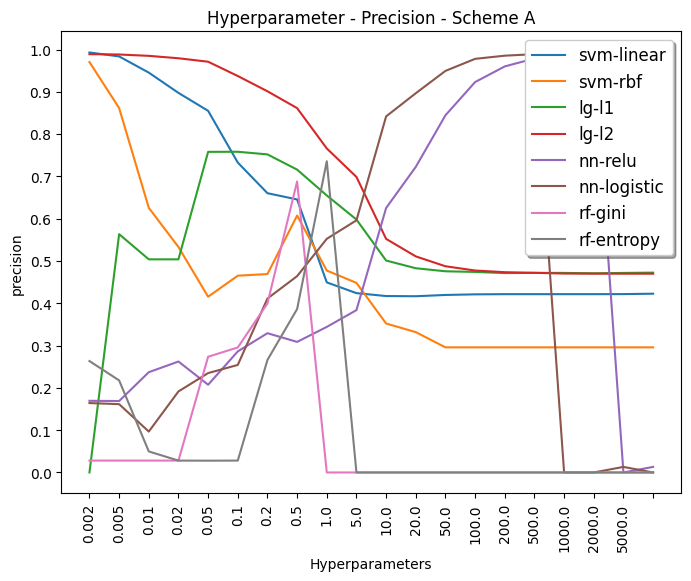

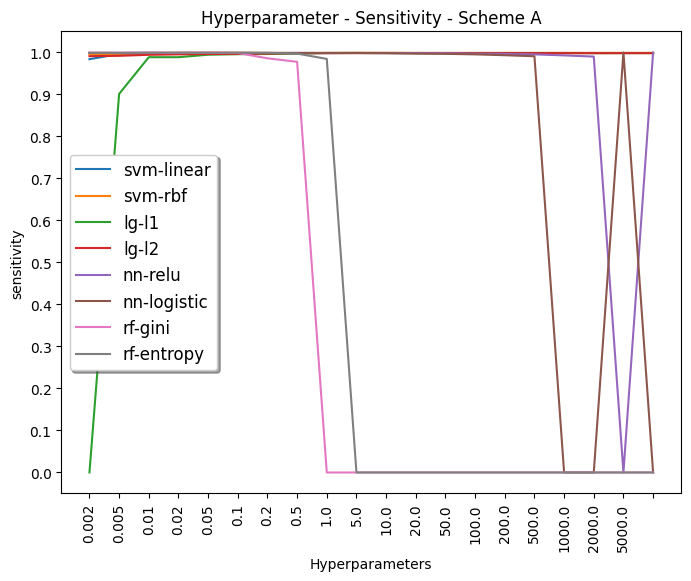

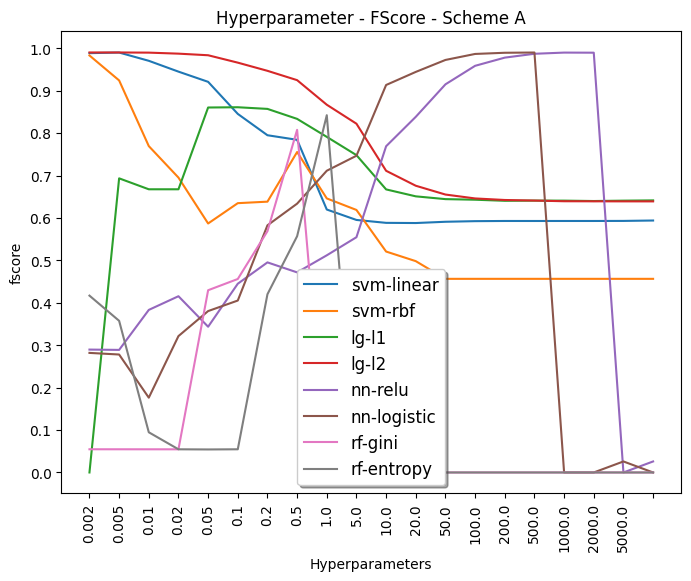

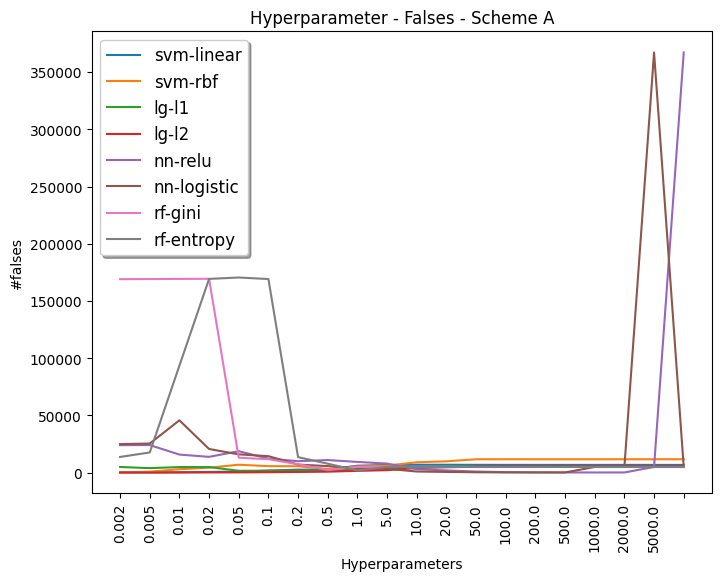

In [9]:
plot_generation(df_precision, "Hyperparameter - Precision - Scheme A", "precision", "A_FEBRL_precision.png")
plot_generation(df_sensitivity, "Hyperparameter - Sensitivity - Scheme A", "sensitivity", "A_FEBRL_sensitivity.png")
plot_generation(df_fscore, "Hyperparameter - FScore - Scheme A", "fscore", "A_FEBRL_fscore.png")
plot_generation(df_nb_false, "Hyperparameter - Falses - Scheme A", "#falses", "A_FEBRL_falses.png")

df_precision.to_csv(PATH_OUTPUT_CSV + "A_FEBRL_precision.csv")
df_sensitivity.to_csv(PATH_OUTPUT_CSV + "A_FEBRL_sensitivity.csv")
df_fscore.to_csv(PATH_OUTPUT_CSV + "A_FEBRL_fscore.csv")
df_nb_false.to_csv(PATH_OUTPUT_CSV + "A_FEBRL_falses.csv")

Training bagging model

In [10]:
print("BAGGING PERFORMANCE:\n")
#modeltypes = ["svm", "nn", "lg", "rf"]
#modeltypes_2 = ["linear", "relu", "l2", "entropy"]
#modelparams = [0.002, 500, 0.005, 0.5]
modeltypes = ['svm', 'nn', 'lg'] 
modeltypes_2 = ['linear', 'relu', 'l2']
modelparams = [0.005, 100, 0.2]

model_raw_score = [0] * len(modeltypes)
model_binary_score = [0] * len(modeltypes)
model_i = 0

nFold = 10

df_bagging = pd.DataFrame(columns=["model", "no_false", "confusion_matrix", "precision", "sensitivity", "no_links",
        "F-score", "true_pos", "true_neg", "false_pos", "false_neg"])

kf = KFold(n_splits=nFold)

for model_i in range(len(modeltypes)):
    modeltype = modeltypes[model_i]
    modeltype_2 = modeltypes_2[model_i]
    modelparam = modelparams[model_i]

    print(modeltype, "per fold:")
    iFold = 0
    result_fold = [0] * nFold
    final_eval_fold = [0] * nFold

    for train_index, _ in kf.split(X_febrl3_train):
        X_febrl3_train_fold = X_febrl3_train[train_index]
        y_febrl3_train_fold = y_febrl3_train[train_index]
        md = model_training(modeltype, modelparam, X_febrl3_train_fold, y_febrl3_train_fold, modeltype_2)
        result_fold[iFold] = md.predict(X_febrl4_test)
        final_eval_fold[iFold] = performance_evaluation(y_febrl4_test, result_fold[iFold])
        print("Fold", str(iFold), final_eval_fold[iFold])
        iFold = iFold + 1
    bagging_raw_score = np.average(result_fold, axis=0)
    bagging_binary_score = np.copy(bagging_raw_score)
    bagging_binary_score[bagging_binary_score > 0.5] = 1
    bagging_binary_score[bagging_binary_score <= 0.5] = 0
    bagging_eval = performance_evaluation(y_febrl4_test, bagging_binary_score)
    print(modeltype, "bagging:", bagging_eval)
    print("")
    model_raw_score[model_i] = bagging_raw_score
    model_binary_score[model_i] = bagging_binary_score

    model = (modeltypes[model_i] + " - " + modeltypes_2[model_i] + " - " + str(modelparams[model_i]))
    df_bagging.loc[model_i] = [model] + [v for _, v in bagging_eval.items()]

thres = 0.99

print("STACKING PERFORMANCE:\n")
stack_raw_score = np.average(model_raw_score, axis=0)
stack_binary_score = np.copy(stack_raw_score)
stack_binary_score[stack_binary_score > thres] = 1
stack_binary_score[stack_binary_score <= thres] = 0
stacking_eval = performance_evaluation(y_febrl4_test, stack_binary_score)
print(stacking_eval)

model = "stack bagging"
df_bagging.loc[len(df_bagging)] = [model] + [v for _, v in stacking_eval.items()]


BAGGING PERFORMANCE:

svm per fold:
Fold 0 {'no_false': 234, 'confusion_matrix': [4878, 218, 16, 366961], 'precision': 0.957221350078493, 'sensitivity': 0.9967306906416019, 'no_links': 5096, 'F-score': 0.9765765765765766, 'true_pos': 4878, 'true_neg': 366961, 'false_pos': 218, 'false_neg': 16}
Fold 1 {'no_false': 259, 'confusion_matrix': [4878, 243, 16, 366936], 'precision': 0.9525483304042179, 'sensitivity': 0.9967306906416019, 'no_links': 5121, 'F-score': 0.9741387918122816, 'true_pos': 4878, 'true_neg': 366936, 'false_pos': 243, 'false_neg': 16}
Fold 2 {'no_false': 261, 'confusion_matrix': [4878, 245, 16, 366934], 'precision': 0.9521764591059926, 'sensitivity': 0.9967306906416019, 'no_links': 5123, 'F-score': 0.9739442946990117, 'true_pos': 4878, 'true_neg': 366934, 'false_pos': 245, 'false_neg': 16}
Fold 3 {'no_false': 235, 'confusion_matrix': [4877, 218, 17, 366961], 'precision': 0.9572129538763494, 'sensitivity': 0.996526358806702, 'no_links': 5095, 'F-score': 0.976474121533687, 

Saving bagging results

In [31]:
df_bagging.to_csv(PATH_OUTPUT_CSV + "A_FEBRL_bagging.csv")